In [31]:
import joblib
import numpy as np
import pandas as pd
import os

import plotly.express as px
import plotly.figure_factory as ff

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import ( accuracy_score, f1_score, r2_score, mean_squared_error )
from sklearn.model_selection import ( GridSearchCV, train_test_split )
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import( OneHotEncoder, StandardScaler, LabelEncoder )

In [32]:
dataset = pd.read_csv(r'src/dataset.csv', delimiter=',', on_bad_lines='skip')

corr_matrix = round(dataset.corr(), 4)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist(),
                                  )

fig.show()

# numVotes

In [33]:
print(len(dataset))

dfnumVotes = dataset.sort_values(by=['numVotes'])

dfnumVotes = dfnumVotes[dfnumVotes['numVotes'] < 20000]
dfnumVotes = dfnumVotes[dfnumVotes['numVotes'] > 200]

print(len(dfnumVotes))

px.histogram(dfnumVotes["numVotes"])

88648
47417


# duree

In [34]:
dfduree = dfnumVotes.sort_values(by=['duree'])
dfduree = dfduree[dfduree['duree'] < 150]
dfduree = dfduree[dfduree['duree'] > 40]

print(len(dfduree))

px.histogram(dfduree["duree"])

45780


# year

In [35]:
dfyear = dfduree.sort_values(by=['year'])
dfyear = dfyear[dfyear['year'] < 2017]
dfyear = dfyear[dfyear['year'] > 2000]

print(len(dfyear))

px.histogram(dfyear["year"])

17325


# genre

14522


<AxesSubplot:>

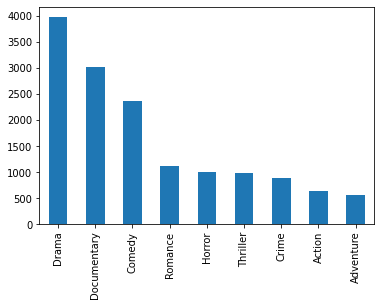

In [36]:
dfgenre = dfyear
countGenre = dfgenre['genre'].value_counts()
countGenre = countGenre[countGenre[:] > 400 ] # Drop Less than 5% of biggest genre.
listGenre = countGenre.keys().tolist()

dfgenre = dfgenre[dfgenre['genre'].isin(listGenre)]

print(len(dfgenre))

countGenre.plot(kind='bar')

# parentalAdvisor

Not Rated    5969
R            3564
PG-13        1223
Name: parentalAdvisor, dtype: int64
10756


<AxesSubplot:>

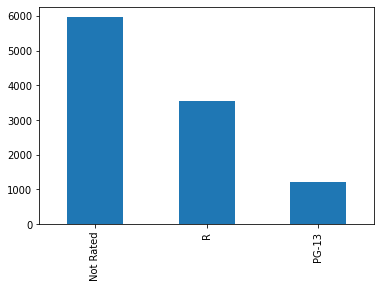

In [37]:
dfparentalAdvisor = dfgenre
countAdvisor = dfparentalAdvisor['parentalAdvisor'].value_counts()

countAdvisor = countAdvisor[countAdvisor[:] > 1000 ] # Drop Less than 5% of biggest genre.
print(countAdvisor)
listGenre = countAdvisor.keys().tolist()

dfparentalAdvisor = dfparentalAdvisor[dfparentalAdvisor['parentalAdvisor'].isin(listGenre)]

print(len(dfparentalAdvisor))

countAdvisor.plot(kind='bar')

# imdbRating

In [38]:
dfimdbRating = dfparentalAdvisor.sort_values(by=['imdbRating'])

print(len(dfimdbRating))

px.histogram(dfimdbRating["imdbRating"])

10756


# Drop Lines 

In [39]:
datasetWithoutOutlier = dfimdbRating.drop(columns=['tconst', 'numVotes'])

In [40]:
target_name = 'imdbRating'

## Graph de correlation 

In [41]:


corr_matrix = round(datasetWithoutOutlier.corr(), 4)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist(),
                                  )


fig.show()

## Separation Varibles / Target

In [42]:
## Separation valeurs explicative et valeur cible
Y = datasetWithoutOutlier[:][target_name]
X = datasetWithoutOutlier.drop(columns= [target_name])

## Separation en train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=0, stratify=Y)
# stratify = Y # option pour même ratio de réponse que sur la table Y.
print(X)
print(Y)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## Pipeline Préprocessor 

In [ ]:
## Médiane quantitative & plus fréquent qualitatif



# Create pipeline for numeric features
numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
X_test = preprocessor.transform(X_test) # Preprocessing copieur


## Training
### Random Forest

In [ ]:
model = RandomForestRegressor(n_jobs=-1, verbose=2) 
# n_jobs=-1 -> Utilisation de tout les cores 
# verbose=2 -> Affiche toutes les info de constructions

## Prediction
### Random Forest model : Grid search

In [ ]:

# Grid of values to be tested

params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}

gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
# 36m 6.5s 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    7.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

building tree 1 of 60building tree 2 of 60building tree 3 of 60


building tree 4 of 60building tree 5 of 60
building tree 6 of 60

building tree 7 of 60building tree 8 of 60

building tree 9 of 60
building tree 10 of 60building tree 11 of 60

building tree 12 of 60building tree 13 of 60

building tree 14 of 60
building tree 15 of 60
building tree 16 of 60
building tree 17 of 60
building tree 18 of 60
building tree 19 of 60
building tree 20 of 60building tree 21 of 60

building tree 22 of 60
building tree 23 of 60
building tree 24 of 60
building tree 25 of 60
building tree 26 of 60
building tree 27 of 60building tree 28 of 60
building tree 29 of 60building tree 30 of 60


building tree 31 of 60
building tree 32 of 60


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s


building tree 33 of 60
building tree 34 of 60
building tree 35 of 60
building tree 36 of 60
building tree 37 of 60
building tree 38 of 60building tree 39 of 60

building tree 40 of 60
building tree 41 of 60
building tree 42 of 60
building tree 43 of 60building tree 44 of 60

building tree 45 of 60
building tree 46 of 60
building tree 47 of 60
building tree 48 of 60
building tree 49 of 60
building tree 50 of 60
building tree 51 of 60
building tree 52 of 60
building tree 53 of 60
building tree 54 of 60
building tree 55 of 60
building tree 56 of 60
building tree 57 of 60
building tree 58 of 60
building tree 59 of 60building tree 60 of 60



[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    2.1s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, verbose=2),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 40, 60, 80, 100]})

In [ ]:
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)

...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 60}


In [ ]:
Y_train_pred = gridsearch.predict(X_train) # Predictions on training set
Y_test_pred = gridsearch.predict(X_test) # Prédictions on test set 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:    0.0s finished


#### Grid search : Random Forest

In [ ]:
# Compute mean squared error
mse = mean_squared_error(Y_test, Y_test_pred)
print("Mean squared error : ", mse)
print("Mean error : ", mse**0.5)


Mean squared error :  1.1434382488978314
Mean error :  1.0693167205733909


In [ ]:
fig = px.scatter(x = Y_test, y = Y_test_pred, opacity=0.2, width=650, height=600, marginal_y='violin')
fig.update_layout( margin=dict(l=20, r=10, t=10, b=10) )
fig.show()

## Save Model

In [ ]:
# save
# joblib.dump(gridsearch.best_estimator_, "export/random_forest.joblib", compress=3)